## Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy.matlib
import mat73
import colorcet as cc

from numpy import asarray
from scipy import stats, signal, io
from scipy.ndimage import median_filter as medfilt
from scipy.special import kl_div
from matplotlib import ticker

from sklearn.metrics import r2_score, normalized_mutual_info_score as nmi, accuracy_score as acc
from sklearn.utils.extmath import randomized_svd as rsvd
from sklearn.preprocessing import normalize, StandardScaler
from hmmlearn import hmm

from utils import tic, toc, generate_color_gradient

%matplotlib inline

In [2]:
from matplotlib.colors import ListedColormap
import seaborn as sns
palette = sns.color_palette("husl", 6)
cmap = ListedColormap(colors=palette)

In [3]:
font = {'family' : 'arial',
        'size'   : 16}
plt.rc('font', **font)

In [4]:
def plot_allen(ax):
    allen_ccf = mat73.loadmat(data_dir + '/allen_ccf_overlay.mat')['allen_ccf']
    for i in range(len(allen_ccf)):
        temp1 = allen_ccf[i]
        ax.plot(temp1[:,0],temp1[:,1],'w',lw=.5)

In [5]:
def create_hmm_transmat(num_states, stay_prob=.9):

    transmat = np.zeros((num_states, num_states))
    for i in range(num_states):
        transmat[i,i] = stay_prob
        
    # Assign move probabilities off the diagonal (equally split)
    move_prob = (1 - stay_prob) / (num_states - 1)  # To ensure the row sums to 1
    for i in range(num_states):
        for j in range(num_states):
            if i != j:
                transmat[i,j] = move_prob
                    
    return transmat

## Load and preprocess data

In [6]:
data_dir = '/home/ryanr/widefield'
outdir = '/home/ryanr/Allen/arousal_final/model_predictions'
figdir = '/home/ryanr/Allen/arousal_final/figs'
mask = io.loadmat(data_dir+'/newmask.mat')
mask = mask["newmask"]
mask.dtype = bool
mask_long = mask.reshape(16384,order='F')
allen_ccf = mat73.loadmat(data_dir + '/allen_ccf_overlay.mat')['allen_ccf']

In [7]:
from numpy.random import seed
seed(1)

## Analysis

In [8]:
## Set modeling parameters

subjects = [4,5,6,7,8,9,10]
Fs = 20 # sampling frequency
dt = 1/Fs

## Example mouse

In [9]:
modality='jrgeco'
num_PCs = 3
k = 6
s = 0

subj = subjects[s]

vh = np.load(outdir + '/../PCs/' + str(subj) + '_' + modality + '_spatial_modes.npy')

ytest = np.load(outdir + '/' + str(subj) + '_' + modality + '_ytest.npy')
ytest_hat1 = np.load(outdir + '/' + str(subj) + '_' + modality + '_nodelay_lin_ytest_hat.npy')
ytest_hat2 = np.load(outdir + '/' + str(subj) + '_' + modality + '_delay_nonlin_ytest_hat.npy')

# Projection
data = ytest@vh.T[:,:num_PCs]
data1 = ytest_hat1@vh.T[:,:num_PCs]
data2 = ytest_hat2@vh.T[:,:num_PCs]

# Whitening (feature-wise standardization)
data = stats.zscore(data,axis=0)
data1 = stats.zscore(data1,axis=0)
data2 = stats.zscore(data2,axis=0)

transmat_prior = create_hmm_transmat(k, stay_prob=.9)

hmm0 = hmm.GaussianHMM(n_components=k, init_params='mc', params='mcst', n_iter=100, covariance_type='diag', random_state=1)
hmm0.startprob_ = np.ones((k))/k
hmm0.transmat_ = transmat_prior.copy()
hmm0.fit(data)

# Fit transition dynamics
hmm1 = hmm.GaussianHMM(n_components=k, init_params='', params='st', n_iter=100, covariance_type='diag', random_state=1)
hmm1.means_ = hmm0.means_.copy()
hmm1.covars_ = np.array([np.diagonal(hmm0.covars_[i]) for i in range(hmm0.covars_.shape[0])])#[::num_PCs,0] #for spherical
hmm1.startprob_ = hmm0.startprob_.copy()
hmm1.transmat_ = transmat_prior.copy()
hmm1.fit(data)

hmm2 = hmm.GaussianHMM(n_components=k, init_params='', params='st', n_iter=100, covariance_type='diag', random_state=1)
hmm2.means_ = hmm0.means_.copy()
hmm2.covars_ = np.array([np.diagonal(hmm0.covars_[i]) for i in range(hmm0.covars_.shape[0])])
hmm2.startprob_ = hmm0.startprob_.copy()
hmm2.transmat_ = transmat_prior.copy()
hmm2.fit(data2)

hmm3 = hmm.GaussianHMM(n_components=k, init_params='', params='st', n_iter=100, covariance_type='diag', random_state=1)
hmm3.means_ = hmm0.means_.copy()
hmm3.covars_ = np.array([np.diagonal(hmm0.covars_[i]) for i in range(hmm0.covars_.shape[0])])
hmm3.startprob_ = hmm0.startprob_.copy()
hmm3.transmat_ = transmat_prior.copy()
hmm3.fit(data1)

states = hmm0.predict(data)

In [10]:
## Re-order according to dominant cycle
temp = hmm0.transmat_.copy()
evals, evecs = np.linalg.eig(temp)
complex_inds = [i for i in range(len(evals)) if np.imag(evals[i]) != 0]

if complex_inds:
    # Select one of the complex conjugate eigenvalues
    complex_ind = complex_inds[0]
    dominant_evec = evecs[:,complex_ind]

    # Compute the phases of the elements of the eigenvector
    phases = np.angle(dominant_evec)

    # Sort the eigenvector elements according to phase
    sorted_inds = np.argsort(phases)

else:
    print('No complex eigenvalues')

In [11]:
cmap.colors

[(0.9677975592919913, 0.44127456009157356, 0.5358103155058701),
 (0.7350228985632719, 0.5952719904750953, 0.1944419133847522),
 (0.3126890019504329, 0.6928754610296064, 0.1923704830330379),
 (0.21044753832183283, 0.6773105080456748, 0.6433941168468681),
 (0.23299120924703914, 0.639586552066035, 0.9260706093977744),
 (0.9082572436765556, 0.40195790729656516, 0.9576909250290225)]

In [12]:
## plot colors in temporal order
# temp = [cmap.colors[i] for i in sorted_inds]
# sns.palplot(temp)

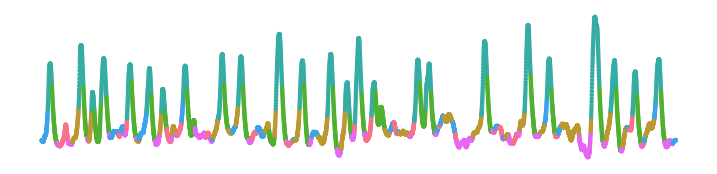

In [13]:
start = 872
lim = 8374-start
plt.figure(figsize=(9,2))
plt.scatter(np.arange(lim),data[start:start+lim,0],5,c=states[start:start+lim],cmap=cmap)
plt.axis('off')
plt.show()

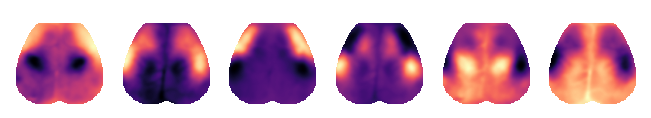

In [14]:
fig, axes = plt.subplots(1,k,layout='compressed')

c1 = .7
axes = axes.flatten()

for i, ax in enumerate(axes):
    temp = hmm0.means_[sorted_inds,:][i,:]@vh[:num_PCs,:]
    #temp = hmm0.means_[i,:]@vh[:num_PCs,:]
    temp = temp.reshape(-1,1)
    outmat1 = np.zeros([16384,1], dtype=np.single)
    outmat1[mask_long] = temp
    outmat1 = np.ma.masked_where(outmat1==0, outmat1)
    outmat1 = outmat1.reshape(128,128,order='F')
    
    ax.imshow(outmat1, cmap = 'magma')
        
    #plot_allen(ax)

    ax.axis('off')
    
plt.savefig(figdir + '/hmm_maps.pdf', dpi=300, transparent=True)   

plt.show()

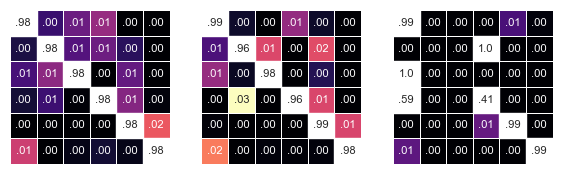

In [15]:
fig, axes = plt.subplots(1,3,figsize=(7,2))

axes = axes.flatten()

for i, ax in enumerate(axes):
    
    if i==0:
        temp = hmm1.transmat_.copy() # original
        
    elif i==1:
        temp = hmm2.transmat_.copy() # latent model
        
    else:
        temp = hmm3.transmat_.copy() # no embedding
        
    # apply sorting
    temp = temp[sorted_inds,:][:,sorted_inds]
    
    # plot heatmap
    sns_heatmap = sns.heatmap(temp, annot=True, fmt=".2f",
                cbar=0, vmin=0, vmax=.025, cmap='magma', ax=ax, annot_kws={'size': 8}, linewidths=.5)
        
    # White background for diagonal
#     for ii in range(len(temp)):
#         if temp[ii,ii]>.2:
#             ax.add_patch(plt.Rectangle((len(temp)-ii-1,len(temp)-ii-1), 1, 1, color='w', zorder=2))

    for ii in range(len(temp)):
        for jj in range(len(temp)):
            if temp[ii,jj]>.1:
                #ax.add_patch(plt.Rectangle((ii,jj), 1, 1, color='w', zorder=2))
                ax.add_patch(plt.Rectangle((jj, ii), 1, 1, color='white', zorder=2))

    # Remove the leading 0 before the decimal point
    for text in ax.texts:
        if float(text.get_text())<.996:
            # Modify the annotation text to remove leading zero
            text.set_text(text.get_text()[1:])
        else:
            text.set_text(text.get_text()[:-1])
            
    ax.axis('off')
    
#plt.savefig(figdir + '/hmm_transmats.pdf', dpi=300, transparent=True)   


## Group HMM analysis

In [16]:
font = {'family' : 'arial',
        'size'   : 16}
plt.rc('font', **font)

def barplotter(Ks, decode_scores, subjects, modality='jrgeco'):
    
    line_colors = generate_color_gradient(len(subjects)+3, modality)

    fig, ax = plt.subplots(figsize=(5, 5))

    for category in range(len(Ks)):
        for group in range(decode_scores.shape[2]):

            # Background bar
            bar_width = 0.2
            x_values = np.arange(len(Ks))*1.2
            ax.bar(.03+x_values-.2, np.mean(decode_scores,axis=0).T[0],.3,color=[0, 0, 0, 0],edgecolor='k',linewidth=.2)
            ax.bar(.03+x_values+.1, np.mean(decode_scores,axis=0).T[1],.3,color=[0, 0, 0, 0],edgecolor='k',linewidth=.2)        
            ax.bar(.03+x_values+.4, np.mean(decode_scores,axis=0).T[2],.3,color=[0, 0, 0, 0],edgecolor='k',linewidth=.2)

            # Scatter
            x_values = np.zeros(decode_scores.shape[0])+1.2*category
            y_values = decode_scores[:, category, group]

            adjusted_x = x_values-.2 + .3 * group

            for i in range(decode_scores.shape[0]):
                ax.scatter(adjusted_x[i]+.01*i, y_values[i],12,color=line_colors[i])

    for category in range(len(Ks)):

        x_values = np.zeros(decode_scores.shape[0])+1.2*category

        for i in range(decode_scores.shape[0]):
            ax.plot([.01*i+x_values-.2,.01*i+x_values+.1,.01*i+x_values+.4],decode_scores[i,category,:],c=line_colors[i],lw=1,alpha=.1)

    plt.xlabel('# of clusters')
    #plt.ylabel('Accuracy')

    ax.set_xticks(.1+1.2*np.arange(len(Ks)),labels=Ks)

In [17]:
modality='jrgeco'
num_PCs = 3
Ks = [2,3,4,5,6]
decode_scores = np.zeros([len(subjects),len(Ks),3])
likelihoods = np.zeros([len(subjects),len(Ks),3])
klds = np.zeros([len(subjects),len(Ks),3])

for s in range(len(subjects)):
    
    tic()
    
    subj = subjects[s]
    
    vh = np.load(outdir + '/../PCs/' + str(subj) + '_' + modality + '_spatial_modes.npy')
        
    ytest = np.load(outdir + '/' + str(subj) + '_' + modality + '_ytest.npy')
    ytest_hat1 = np.load(outdir + '/' + str(subj) + '_' + modality + '_nodelay_lin_ytest_hat.npy')
    ytest_hat2 = np.load(outdir + '/' + str(subj) + '_' + modality + '_delay_nonlin_ytest_hat.npy')

    # Projection
    data = ytest@vh.T[:,:num_PCs]
    data1 = ytest_hat1@vh.T[:,:num_PCs]
    data2 = ytest_hat2@vh.T[:,:num_PCs]
    
    # Whitening (feature-wise standardization)
    data = stats.zscore(data,axis=0)
    data1 = stats.zscore(data1,axis=0)
    data2 = stats.zscore(data2,axis=0)

    # Clustering
    for k in range(len(Ks)):

        transmat_prior = create_hmm_transmat(Ks[k], stay_prob=0.8)

        # Likelihoods
        hmm0 = hmm.GaussianHMM(n_components=Ks[k], init_params='mc', params='mcst', covariance_type='diag', n_iter=100, random_state=1)
        hmm0.startprob_ = np.ones((Ks[k]))/Ks[k]
        hmm0.transmat_ = transmat_prior.copy()
        hmm0.fit(data)
        likelihoods[s,k,0] = hmm0.score(data)
        likelihoods[s,k,1] = hmm0.score(data2)
        likelihoods[s,k,2] = hmm0.score(data1)

        # Fit transition dynamics
        hmm1 = hmm.GaussianHMM(n_components=Ks[k], init_params='', params='st', n_iter=100, covariance_type='diag', random_state=1)
        hmm1.means_ = hmm0.means_.copy()
        hmm1.covars_ = np.array([np.diagonal(hmm0.covars_[i]) for i in range(hmm0.covars_.shape[0])])#[::num_PCs,0] #for spherical
        hmm1.startprob_ = hmm0.startprob_.copy()
        hmm1.transmat_ = transmat_prior.copy()
        hmm1.fit(data)

        hmm2 = hmm.GaussianHMM(n_components=Ks[k], init_params='', params='st', n_iter=100, covariance_type='diag', random_state=1)
        hmm2.means_ = hmm0.means_.copy()
        hmm2.covars_ = np.array([np.diagonal(hmm0.covars_[i]) for i in range(hmm0.covars_.shape[0])])
        hmm2.startprob_ = hmm0.startprob_.copy()
        hmm2.transmat_ = transmat_prior.copy()
        hmm2.fit(data2)

        hmm3 = hmm.GaussianHMM(n_components=Ks[k], init_params='', params='st', n_iter=100, covariance_type='diag', random_state=1)
        hmm3.means_ = hmm0.means_.copy()
        hmm3.covars_ = np.array([np.diagonal(hmm0.covars_[i]) for i in range(hmm0.covars_.shape[0])])
        hmm3.startprob_ = hmm0.startprob_.copy()
        hmm3.transmat_ = transmat_prior.copy()
        hmm3.fit(data1)
        
        # Accuracy
        states = hmm1.predict(data)
        states1 = hmm3.predict(data1)
        states2 = hmm2.predict(data2)
        states_dummy = np.full(len(states),np.argmax(np.bincount(states)))

        decode_scores[s,k,0] = acc(states,states_dummy)
        decode_scores[s,k,1] = acc(states,states1)
        decode_scores[s,k,2] = acc(states,states2)

        d = hmm0.transmat_.copy()
        a = hmm1.transmat_.copy()
        b = hmm2.transmat_.copy()
        c = hmm3.transmat_.copy()

        # Zero-out low probabilities
        a[a<.005]=1e-10
        a /= np.sum(a,axis=1,keepdims=True)
        b[b<.005]=1e-10
        b /= np.sum(b,axis=1,keepdims=True)
        c[c<.005]=1e-10
        c /= np.sum(c,axis=1,keepdims=True)
        d[d<.005]=1e-10
        d /= np.sum(d,axis=1,keepdims=True)
        
        klds[s,k,0] = np.sum(kl_div(d,a))
        klds[s,k,1] = np.sum(kl_div(d,b))
        klds[s,k,2] = np.sum(kl_div(d,c))

#         # Zero-out diagonals
#         np.fill_diagonal(a,1e-10)
#         np.fill_diagonal(b,1e-10)
#         np.fill_diagonal(c,1e-10)
#         np.fill_diagonal(d,1e-10)
        
#         a /= np.sum(a,axis=1,keepdims=True)
#         b /= np.sum(b,axis=1,keepdims=True)
#         c /= np.sum(c,axis=1,keepdims=True)
#         d /= np.sum(d,axis=1,keepdims=True)

#         klds[s,k,0] = np.sum(kl_div(d,a))
#         klds[s,k,1] = np.sum(kl_div(d,b))
#         klds[s,k,2] = np.sum(kl_div(d,c))

    toc()

Elapsed time is 4.537911415100098 seconds.
Elapsed time is 3.67114520072937 seconds.
Elapsed time is 4.219015598297119 seconds.
Elapsed time is 4.501084804534912 seconds.
Elapsed time is 4.062091827392578 seconds.
Elapsed time is 3.85448956489563 seconds.
Elapsed time is 4.34987735748291 seconds.


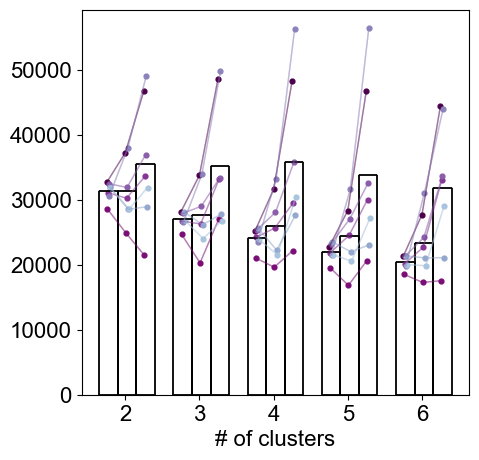

In [18]:
barplotter(Ks, -likelihoods, subjects)
#plt.title('NLL')
plt.savefig(figdir + '/hmm_NLLs.pdf', dpi=300, transparent=True)
plt.show()

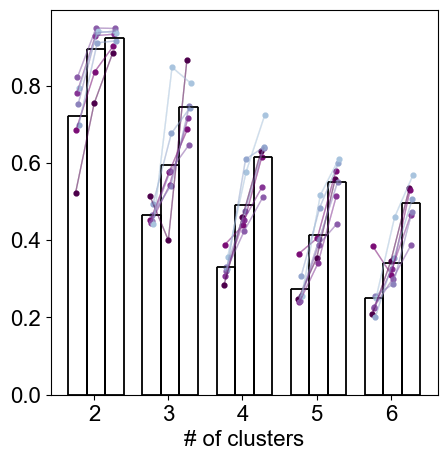

In [19]:
barplotter(Ks, decode_scores, subjects)
#plt.title('Accuracy')
plt.savefig(figdir + '/hmm_acc.pdf', dpi=300, transparent=True) 
plt.show()

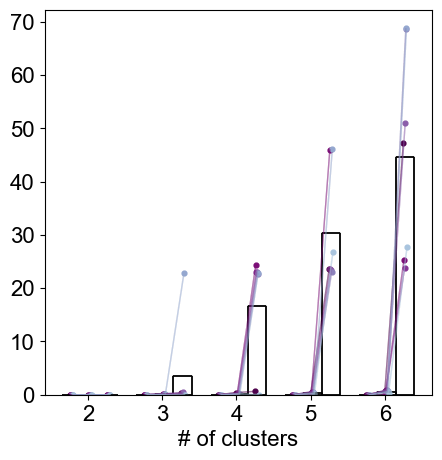

In [20]:
barplotter(Ks, klds, subjects)
#plt.title('KLDs')
plt.savefig(figdir + '/hmm_KLDs.pdf', dpi=300, transparent=True)
plt.show()